In [ ]:
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from bs4 import BeautifulSoup
import time
import math
import redis
import random
import json
import re
from fake_useragent import UserAgent
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import openai
import json
import pandas as pd
import numpy as np
from collections import Counter


In [121]:
redis_client = redis.Redis(host='localhost', port=6380, decode_responses=True)

i = 0
nb_ok = 0
for key in redis_client.scan_iter("listing:*"):
  i += 1

  value = redis_client.get(key)
  if value == "":
     continue

  #data = json.loads(value)
  #data['rent'] = int(data['rent'])
  #redis_client.set(key, json.dumps(data))

  nb_ok += 1
    

print(f"Nb items: {i}")
print(f"Nb items with data: {nb_ok}")


Nb items: 15469
Nb items with data: 4026


## Data cleaning

In [120]:
# get all listings with NO_CANTON
# to-do: remove this cell

def count_no_cantons():
  i = 0
  for key in redis_client.scan_iter("listing:*"):
    value = redis_client.get(key)
    if value == "":
       continue

    data = json.loads(value)

    if data["address"]["canton"] == "NO_CANTON":
      i += 1

  print(f"Keyless: {i}")

count_no_cantons()
print("Cleanup")

for key in redis_client.scan_iter("listing:*"):
  value = redis_client.get(key)
  if value == "":
    continue
  
  data = json.loads(value)
  if data["address"]["canton"] == "NO_CANTON":
    postal_code = data["address"]["postal_code"]
    print(f"No canton => {postal_code}")

    for key2 in redis_client.scan_iter("listing:*"):
      value2 = redis_client.get(key2)
      if value2 == "":
        continue

      data2 = json.loads(value2)
      if data2["address"]["postal_code"] == postal_code and data2["address"]["canton"] != "NO_CANTON":
        print(f"  Found postal code in {key2} => {data2['address']['canton']}")

        data["address"]["canton"] = data2["address"]["canton"]
        redis_client.set(key, json.dumps(data))
        break

    print()

count_no_cantons()

Keyless: 32
Cleanup
No canton => 8553

No canton => 5276

No canton => 2742

No canton => 6745

No canton => 4911

No canton => 9043

No canton => 8547

No canton => 4803

No canton => 6807

No canton => 4853

No canton => 6377

No canton => 6034

No canton => 4802

No canton => 9535

No canton => 8546

No canton => 8104

No canton => 7074

No canton => 9405

No canton => 4228

No canton => 4539

No canton => 9405

No canton => 8113

No canton => 6715

No canton => 5632

No canton => 4932

No canton => 6418

No canton => 8246

No canton => 8228

No canton => 8546

No canton => 4954

No canton => 6484

No canton => 4932

Keyless: 32


## Build the DF

In [126]:
redis_client = redis.Redis(host='localhost', port=6380, decode_responses=True)

df_headers = [
  "type", 
  "rooms",
  "living_space",
  "floor",
  "canton",
  "municipality",
  "postal_code", 
  "wheelchair_access",
  "elevator",
  "balcony_terrace",
  "pets_allowed",
  "new_building",
  "parking_garage",
  "old_building",
  "minergie",
  "swimming_pool",
  "rent",
]

df = pd.DataFrame(columns=df_headers)

for key in redis_client.scan_iter("listing:*"):
  value = redis_client.get(key)
  if value == "":
    continue
  
  data = json.loads(value)
  if data["address"]["canton"] == "NO_CANTON":
    continue

  # Extract the relevant fields
  row = {
    "type": data["type"],
    "rooms": data["rooms"],
    "living_space": data["living_space"],
    "floor": data["floor"],
    "canton": data["address"]["canton"],
    "municipality": data["address"]["municipality"],
    "postal_code": data["address"]["postal_code"],
    "wheelchair_access": data["features"]["wheelchair_access"],
    "elevator": data["features"]["elevator"],
    "balcony_terrace": data["features"]["balcony_terrace"],
    "pets_allowed": data["features"]["pets_allowed"],
    "new_building": data["features"]["new_building"],
    "parking_garage": data["features"]["parking_garage"],
    "old_building": data["features"]["old_building"],
    "minergie": data["features"]["minergie"],
    "swimming_pool": data["features"]["swimming_pool"],
    "rent": data["rent"],
  }
  
  # Append the row to the DataFrame
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

# OK now we need to do some data cleaning

# there are missing values for the rooms
# so we're going to compute the average room for apartments and houses and attribute it to the missing values
avg_rooms_apartment = df[df["type"] == "Apartment"]["rooms"].replace(0, np.nan).mean()
avg_rooms_house = df[df["type"] == "House"]["rooms"].replace(0, np.nan).mean()
df.loc[(df["type"] == "Apartment") & (df["rooms"] == 0), "rooms"] = avg_rooms_apartment
df.loc[(df["type"] == "House") & (df["rooms"] == 0), "rooms"] = avg_rooms_house
df["rooms"] = df["rooms"].apply(lambda x: round(x * 2) / 2)

# we're doing the same for the living space
avg_living_space_apartment = df[df["type"] == "Apartment"]["living_space"].replace(0, np.nan).mean()
avg_living_space_house = df[df["type"] == "House"]["living_space"].replace(0, np.nan).mean()
df.loc[(df["type"] == "Apartment") & (df["living_space"] < 10), "living_space"] = avg_living_space_apartment
df.loc[(df["type"] == "House") & (df["living_space"] < 10), "living_space"] = avg_living_space_house
df["living_space"] = df["living_space"].apply(lambda x: round(x))

# a municipality may have multiple names according to the language
# we only want to keep 1 by applying the following algorithm
# - Get all distinct postal codes.
# - For each postal code, get all the different municipalities.
# - Count how many times each municipality appears for a given postal code.
# - Take the municipality that appears the most often.
# - Apply this municipality to all entries with the same postal code.

# Get all distinct postal codes
postal_codes = df["postal_code"].unique()
# Create a dictionary to store the most common municipality for each postal code
most_common_municipality = {}
# For each postal code, get all the different municipalities and count their occurrences
for postal_code in postal_codes:
  municipalities = df[df["postal_code"] == postal_code]["municipality"]
  most_common = Counter(municipalities).most_common(1)[0][0]
  most_common_municipality[postal_code] = most_common
# Apply the most common municipality to all entries with the same postal code
df["municipality"] = df.apply(lambda row: most_common_municipality[row["postal_code"]], axis=1)




# Dictionary mapping of canton abbreviations to full names
def get_canton_name(abbreviation):
  canton_map = {
    'AG': 'Aargau', 'AR': 'Appenzell Ausserrhoden', 'AI': 'Appenzell Innerrhoden',
    'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'BE': 'Bern', 'FR': 'Fribourg',
    'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Lucerne',
    'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SZ': 'Schwyz',
    'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SG': 'Sankt Gallen', 'TG': 'Thurgau',
    'TI': 'Ticino', 'UR': 'Uri', 'VS': 'Valais', 'VD': 'Vaud', 'ZG': 'Zug', 'ZH': 'Zürich'
  }

  # Return the corresponding full canton name, or None if not found
  return canton_map.get(abbreviation.upper(), None)
df["canton"] = df["canton"].apply(get_canton_name)




# display the final dataframe
df

/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_68893/3109893170.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_68893/3109893170.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  avg_living_space_apartment = df[df["type"] == "Apartment"]["living_space"].replace(0, np.nan).mean()
/var/folders/vt/ylsvf5fn1d7_gznl9zf0z0tr0000gn/T/ipykernel_68893/3109893170.py:70: FutureWarning: 

,type,rooms,living_space,floor,canton,municipality,postal_code,wheelchair_access,elevator,balcony_terrace,pets_allowed,new_building,parking_garage,old_building,minergie,swimming_pool,rent
0,Apartment,3.0,63,3,Basel-Landschaft,Therwil,4106,False,True,True,True,False,False,False,False,False,1745
1,Apartment,4.0,88,3,Neuchâtel,Le Locle,2400,False,False,True,True,False,False,False,False,False,1300
2,Apartment,3.5,79,1,Aargau,Erlinsbach,5015,False,True,True,False,True,True,False,False,False,1490
3,Apartment,1.0,88,1,Jura,Delémont,2800,False,False,True,False,False,False,False,False,False,580
4,Apartment,4.5,160,1,Aargau,Othmarsingen,5504,False,False,True,False,False,True,False,False,False,2490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3998,Apartment,3.5,98,2,Solothurn,Deitingen,4543,True,True,True,True,True,True,False,False,False,2340
3999,Apartment,4.5,108,2,Bern,Langenthal,4900,False,False,True,False,False,False,False,False,False,1450
4000,Apartment,5.0,150,4,Genève,Genève,1209,False,False,False,False,False,True,False,False,False,4300
4001,Apartment,3.0,67,0,Bern,Corgémont,2606,False,False,True,False,False,False,False,False,False,1110


#   EDA

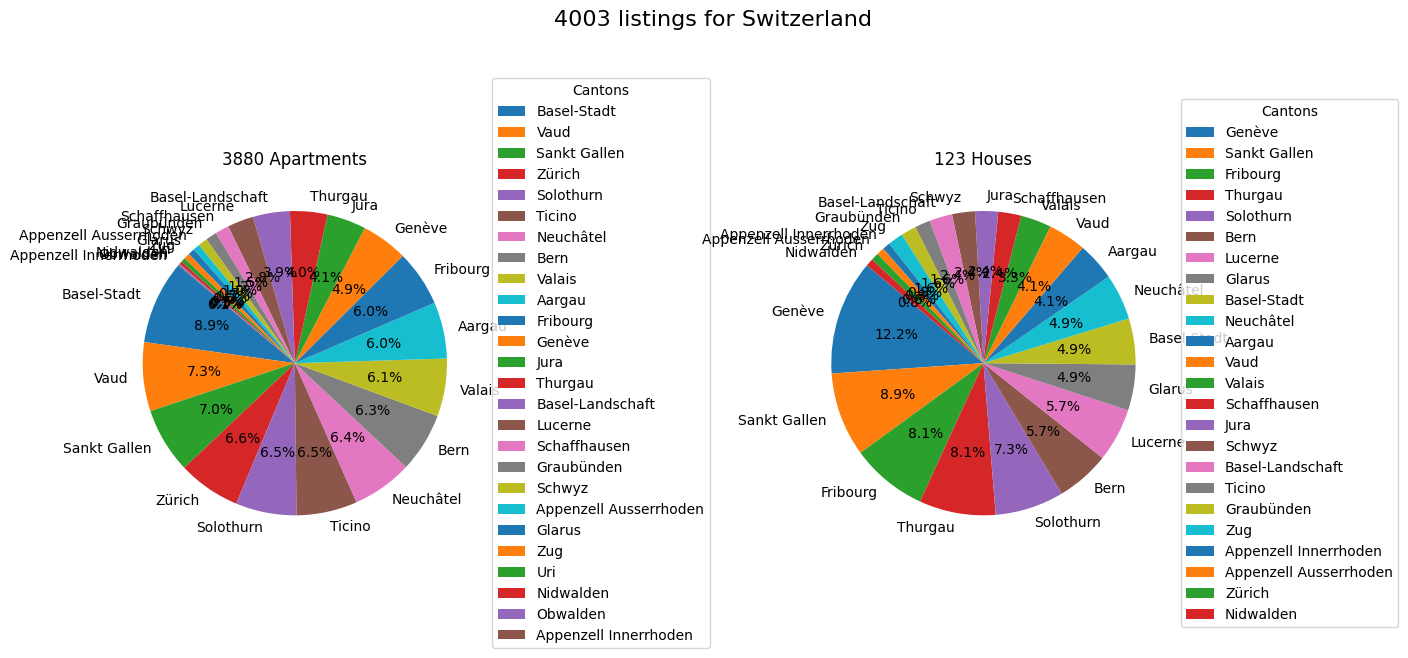

In [127]:
import matplotlib.pyplot as plt

# Ensure plots are displayed inline in the notebook
%matplotlib inline

# Filter the DataFrame for apartments and houses
df_apartments = df[df["type"] == "Apartment"]
df_houses = df[df["type"] == "House"]

# Count the number of listings by canton for apartments and houses
count_apartments_by_canton = df_apartments["canton"].value_counts()
count_houses_by_canton = df_houses["canton"].value_counts()

# Create a figure with two subplots (pie charts)
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for apartments
axes[0].pie(count_apartments_by_canton, labels=count_apartments_by_canton.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title(f'{len(df_apartments)} Apartments')

# Pie chart for houses
axes[1].pie(count_houses_by_canton, labels=count_houses_by_canton.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title(f'{len(df_houses)} Houses')

# Add a legend
axes[0].legend(count_apartments_by_canton.index, title="Cantons", bbox_to_anchor=(1, 0.5), loc="center left")
axes[1].legend(count_houses_by_canton.index, title="Cantons", bbox_to_anchor=(1, 0.5), loc="center left")
fig.suptitle(f'{len(df)} listings for Switzerland', fontsize=16)
# Display the plot
plt.tight_layout()
plt.show()

## prices distribution

## Rent heatmap

There are 994 distinct municipalities.


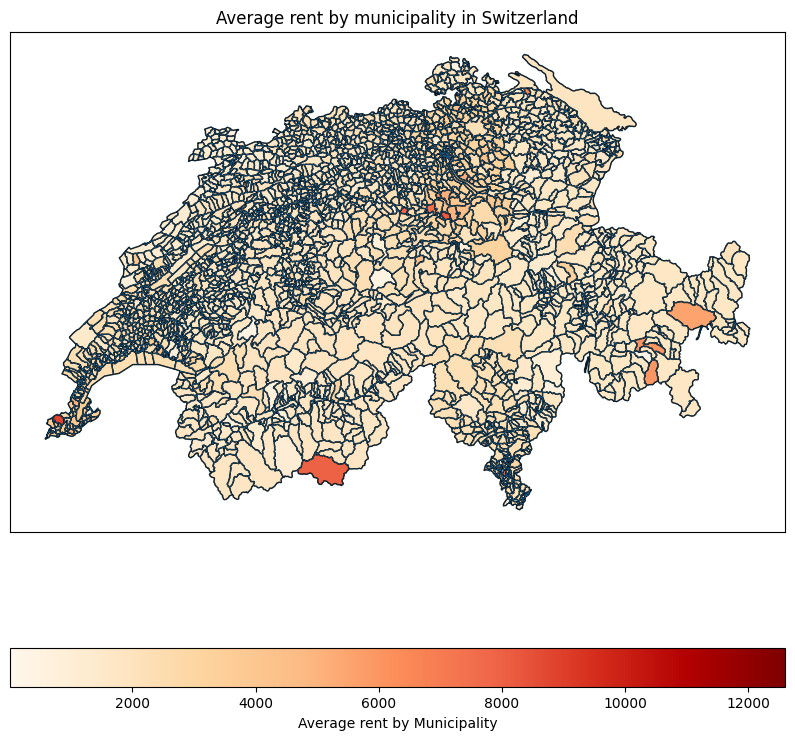

In [137]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Ensure plots are displayed inline in the notebook
%matplotlib inline

# Extract the list of unique municipalities from the DataFrame
municipalities = df["municipality"].unique()

# Compute the average rent for each municipality
rents_avg_per_municipality = []
for municipality in municipalities:
    rents = df[df["municipality"] == municipality]["rent"]
    average = rents.mean()
    rents_avg_per_municipality.append(average)

print(f"There are {len(municipalities)} distinct municipalities.")

# Load Switzerland municipalities shapefile (replace the URL with a local or valid online shapefile for municipalities)
shape_file = 'https://static.grosjean.io/cas/CHE_adm3.shp'
switzerland = gpd.read_file(shape_file)

# Create a DataFrame with the average rent data for municipalities
rent_data_municipality = {
    'municipality': municipalities,
    'average_rent': rents_avg_per_municipality
}
rent_df_municipality = pd.DataFrame(rent_data_municipality)

# Merge the average rent data with the shapefile data using a left join
switzerland = switzerland.merge(rent_df_municipality, left_on='NAME_3', right_on='municipality', how='left')

# Compute the average rent for each canton
cantons = df["canton"].unique()
rents_avg_per_canton = []
for canton in cantons:
    rents = df[df["canton"] == canton]["rent"]
    average = rents.mean()
    rents_avg_per_canton.append(average)

# Create a DataFrame with the average rent data for cantons
rent_data_canton = {
    'canton': cantons,
    'average_rent_canton': rents_avg_per_canton
}
rent_df_canton = pd.DataFrame(rent_data_canton)

# Merge the average rent data for cantons with the shapefile data
switzerland = switzerland.merge(rent_df_canton, left_on='NAME_1', right_on='canton', how='left')

# Fill missing average rent values for municipalities with the average rent of their respective cantons
switzerland['average_rent'] = switzerland.apply(
    lambda row: row['average_rent'] if pd.notna(row['average_rent']) else row['average_rent_canton'], axis=1
)

# Drop the temporary canton average rent column
switzerland = switzerland.drop(columns=['average_rent_canton'])

# Plotting the municipalities with average rent data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
switzerland.boundary.plot(ax=ax, linewidth=0.2)  # Plot boundaries
switzerland.plot(column='average_rent', ax=ax, legend=True,
                 legend_kwds={'label': "Average rent by Municipality",
                              'orientation': "horizontal"},
                 cmap='OrRd', edgecolor='black')

# Title and show plot
plt.xticks([])
plt.yticks([])
plt.title('Average rent by municipality in Switzerland')
plt.show()

There are 26 distinct cantons.


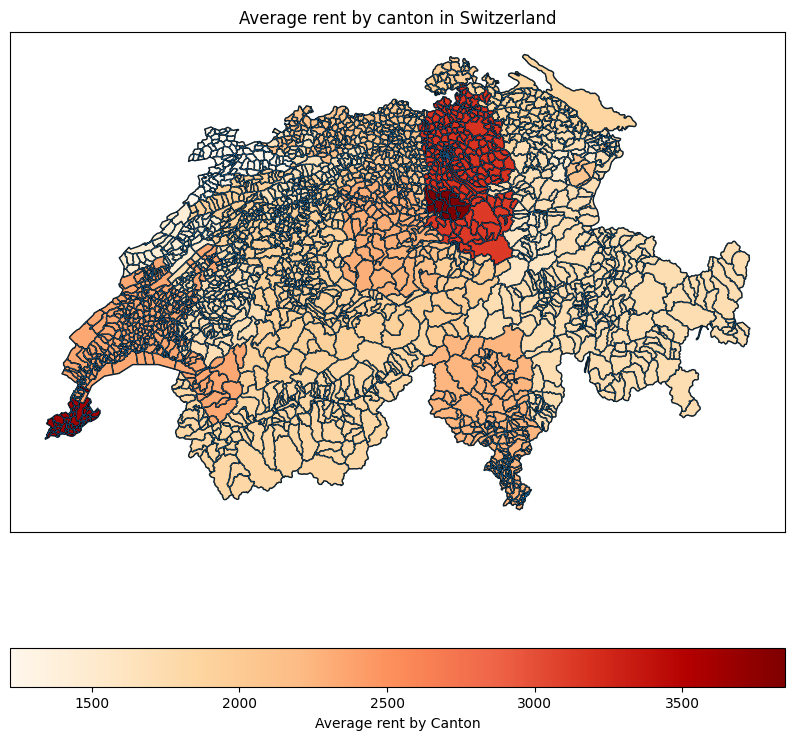

In [133]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Ensure plots are displayed inline in the notebook
%matplotlib inline

# Extract the list of unique cantons from the DataFrame
cantons = df["canton"].unique()
cantons = [canton for canton in cantons if canton != "NO_CANTON"]


# Compute the average rent for each canton
rents_avg_per_canton = []
for canton in cantons:
    rents = df[df["canton"] == canton]["rent"]
    average = rents.mean()
    rents_avg_per_canton.append(average)

print(f"There are {len(cantons)} distinct cantons.")

# Load Switzerland municipalities shapefile (replace the URL with a local or valid online shapefile for municipalities)
shape_file = 'https://static.grosjean.io/cas/CHE_adm3.shp'
switzerland = gpd.read_file(shape_file)

# Create a DataFrame with the average rent data
rent_data = {
    'canton': cantons,
    'average_rent': rents_avg_per_canton
}
rent_df = pd.DataFrame(rent_data)

# Merge the average rent data with the shapefile data
switzerland = switzerland.merge(rent_df, left_on='NAME_1', right_on='canton')

# Plotting the cantons with average rent data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
switzerland.boundary.plot(ax=ax, linewidth=0.2)  # Plot boundaries
switzerland.plot(column='average_rent', ax=ax, legend=True,
                 legend_kwds={'label': "Average rent by Canton",
                              'orientation': "horizontal"},
                 cmap='OrRd', edgecolor='black')

# Title and show plot
plt.xticks([])
plt.yticks([])
plt.title('Average rent by canton in Switzerland')
plt.show()